# To Vaccinate or Not to Vaccinate Challenge by Zindi

## 1. Importing packages and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from transformers import TFBertModel, BertTokenizer
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model

from sklearn.metrics import auc
from sklearn.metrics import roc_curve

import warnings 
warnings.filterwarnings("ignore")

np.random.seed(42)
np.random.RandomState(42)

RandomState(MT19937) at 0x1EF2D820340

In [2]:
train_set = pd.read_csv('Train.csv')
test_set = pd.read_csv('Test.csv')
submission = pd.read_csv('SampleSubmission.csv')

## 2. Exploratory Data Analysis

In [3]:
train_set.sample(5)

,tweet_id,safe_text,label,agreement
6252,P80FMANE,<user> oh because the measles outbreak in Cali...,1.0,1.000000
4684,S71DRG7D,<url>\nJon Stewart turns to zombies to explain...,0.0,1.000000
1731,J8NCS086,Dr. Art Caplan talks about ethical issue in gl...,1.0,1.000000
4742,M5V3TKEZ,Does your kid need vaccinations in Calif? <use...,0.0,0.666667
4521,49H88U2J,"I am now vaccinated for HPV, Hep A &amp; B, an...",1.0,1.000000


In [4]:
len(train_set)

10001

 0.000000    49.08
 1.000000    40.53
-1.000000    10.38
 0.666667     0.01
Name: label, dtype: float64

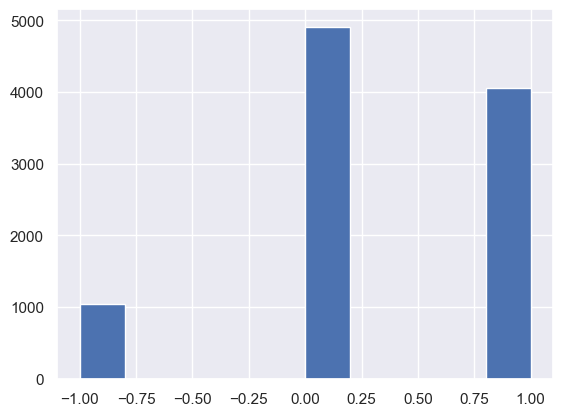

In [5]:
display(train_set["label"].value_counts(normalize = True)*100)
plt.hist(data=train_set, x="label")
plt.show()

In [6]:
for index in train_set.index:
    if train_set.loc[index, 'label'] == 0.666667:
        train_set.loc[index, 'label'] = 1

In [7]:
test_set.sample(5)

,tweet_id,safe_text
2677,II69E4RK,<user> Right. Totally. And the record incidenc...
169,146W4L0B,"So scared of ebola, I'm going for a vaccine 😳"
2097,EK6LT2QV,“<user> Vaccines Save Lives: We welcome new re...
3296,MQP0H9DO,Better get your kids vaccinated so they don't ...
2300,G0VSFANS,Great info from WJSU news director and WJTVs <...


In [8]:
train_set.isnull().sum()

tweet_id     0
safe_text    0
label        1
agreement    2
dtype: int64

In [9]:
train_set.dropna(inplace=True)

## 3. Preprocessing

In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [11]:
def preprocess_tweet(tweet):
    encoded_tweet = tokenizer.encode_plus(
        tweet,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors='tf'
    )
    return encoded_tweet['input_ids'], encoded_tweet['attention_mask']

In [12]:
tweets = train_set['safe_text'].values[:7000]
input_ids = []
attention_masks = []
for tweet in tweets:
    encoded_tweet, attention_mask = preprocess_tweet(tweet)
    input_ids.append(encoded_tweet)
    attention_masks.append(attention_mask)
input_ids_train = tf.concat(input_ids, axis=0)
attention_masks_train = tf.concat(attention_masks, axis=0)

## 4. Fine-tune the BERTweet model with 70% of the data

In [13]:
input_ids = Input(shape=(128,), dtype=tf.int32)
attention_masks = Input(shape=(128,), dtype=tf.int32)
bert_output = model.bert(input_ids, attention_mask=attention_masks)[1]
dropout = Dropout(0.1)(bert_output)
dense = Dense(1, activation='tanh')(dropout)
model = Model(inputs=[input_ids, attention_masks], outputs=dense)

In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), loss='MeanSquaredError', metrics=['RootMeanSquaredError'])

In [15]:
labels = train_set['label'].values[:7000]

In [16]:
model.fit([input_ids_train, attention_masks_train], labels, epochs=3, batch_size=32)

Epoch 1/3
219/219 [==============================] - 2699s 12s/step - loss: 0.4186 - root_mean_squared_error: 0.6470
Epoch 2/3
219/219 [==============================] - 2059s 9s/step - loss: 0.3125 - root_mean_squared_error: 0.5590
Epoch 3/3
219/219 [==============================] - 2529s 12s/step - loss: 0.2108 - root_mean_squared_error: 0.4591


## 5. Test the model on the rest of the train data

In [17]:
tweets = train_set['safe_text'].values[7000:]
input_ids = []
attention_masks = []
for tweet in tweets:
    encoded_tweet, attention_mask = preprocess_tweet(tweet)
    input_ids.append(encoded_tweet)
    attention_masks.append(attention_mask)
input_ids_test = tf.concat(input_ids, axis=0)
attention_masks_test = tf.concat(attention_masks, axis=0)

In [18]:
y_pred = model.predict([input_ids_test, attention_masks_test])

94/94 [==============================] - 294s 3s/step


I used the root mean squared error (RMSE) as a metric to evaluate the model on the rest of the data

In [19]:
from sklearn.metrics import mean_squared_error

In [20]:
mean_squared_error(train_set['label'].values[7000:], [item for sublist in y_pred for item in sublist], squared=False)

0.5758828182513256

## 6. Predict the Test set and filling the submission file

In [21]:
test_set.isnull().sum()

tweet_id     0
safe_text    1
dtype: int64

In [22]:
test_set.dropna(inplace=True)

In [23]:
tweets = test_set['safe_text'].values
input_ids = []
attention_masks = []
for tweet in tweets:
    encoded_tweet, attention_mask = preprocess_tweet(tweet)
    input_ids.append(encoded_tweet)
    attention_masks.append(attention_mask)
input_ids_test = tf.concat(input_ids, axis=0)
attention_masks_test = tf.concat(attention_masks, axis=0)

In [24]:
y = model.predict([input_ids_test, attention_masks_test])

162/162 [==============================] - 504s 3s/step


In [25]:
test_set['label'] = y
for index in submission.index:
    id_ = submission.loc[index, 'tweet_id']
    if id_ in test_set['tweet_id'].values:
        target = test_set[test_set['tweet_id']==id_]['label'].values[0]
    submission.loc[index, 'label'] = float(target)

In [28]:
submission['label'].describe()

count    5177.000000
mean        0.214010
std         0.490853
min        -0.994967
25%        -0.092598
50%         0.086811
75%         0.666262
max         0.997862
Name: label, dtype: float64

In [26]:
submission.to_csv('first_submission_bert4.csv', index=False)

I had a score of `0.561537011` on `Zindi`